In [181]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
import xgboost as xgb
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from math import floor
from scipy.sparse import hstack
from scipy.sparse import load_npz
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'sans',    
        'weight' : "normal",
        'size'   : 13}

plt.rc('font', **font)

# Set to true if you wish to re-run hyperparameters optimization (may take hours)
OPTIMIZE = False

In [182]:
from src.visualization.vert_barplot import vert_barplot

# Study: Hospital readmission of patients with diabetes

**Index**

1. [Problem understanding](#Problem-understanding)
2. [Data understanding](#Data-understanding)
3. [Data preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [References](#references)

<a id="problem-understanding"></a>
## 1. Problem understanding

Hospital readmission (particularly within 30 days of discharge) is seen as a world-wide high-priority health care quality measure and target for cost reduction. (Rubin, 2015) The choice of a 30-day readmission window as a measure of readmission is because such length of time is likely attributable to the quality of care during the index hospitalization, thus representing a preventable outcome. (Graham et al., 2018) 

Readmissions have a huge negative economical impact on hospitals. The Patient Protection and Affordable Care Act in the United States established that Centers for Medicare and Medicaid Services (CMS) would impose financial penalties on hospitals for excessive readmissions within 30 days of hospital discharge. That being said, one in five Medicare beneficiaries is readmitted within 30 days, at a cost of over $26 billion per year, with diabetes being a major contributor to risk for hospital readmission. (Soh et al., 2020) 

Thus, to encourage improvement in the quality of care and a reduction in unnecessary health expense, policymakers, reimbursement strategists, and the United States government have made reducing 30-day hospital readmissions a national priority.

It is clear that a more complete understanding of the underlying causes of readmission is needed to reduce its rate. (Lepin et al., 2014) Therefore, any insights on these causes would cause a positive impact in health policies.

### Assumptions

Why would a patient be early readmitted in the first? Here are a few hypotheses:

- Patient isn't properly diagnosed as diabetic in the first admission;
- Ineffectiveness of treatment during past hospitalizations, namely
    - insufficient number of exams;
    - insufficient medical intervention (medication change or procedures);
- Poor patient health.

One study showed that patients often felt that their readmissions were preventable and linked them to issues with “discharge timing, follow-up, home health and skilled services” (Smeraglio et al., 2019)
 
Patient characteristics such as gender, age, race, and comorbidities, may affect the outcomes (Soh et al. 2020), so they could be used to model patient early readmission. Furthermore, a well-known index adopted by health practitioners called *LACE* takes into account four other variables:

- the length of stay;
- whether the patient was admitted through the emergency department or came voluntarily;
- whether or not the patient has more than one disease or disorder;
- and the number of emergency department visits in the previous six months before admission.

All these are a good baseline to start off with. But there are other variables that could also be assessed, such as:

- type of prescribed medication;
- whether patient was successfully discharged to their home;
- most frequent comorbidities among diabetic and non-diabetic patients;
- number of medical interventions during the inpatient setting.

<u>**Objective**</u>

In this work I will try to answer the following questions:

- Are readmitted diabetic patients correctly diagnosed in their first admission?
- Given that HbA1c values are key for planning the diabetic patient's medication (according to the literature), how often HbA1c exams are asked by physicians in the inpatient setting?
- Are readmitted diabetic patients receiving appropriate medical intervention, like change in their medication or medical procedures if need be?
- Which variables are the strongest readmission predictors?
- And finally, would it be possible to create a predictive model for early readmission? Such a model could help plan interventions for high-risk patients and reduce emotional and financial costs for both patients and hospitals respectively. The target variable is going to be unplanned readmissions that happen within 30 days of discharge from the initial admission, since this is the field standard.

The proposed predictive model should be **interpretable**; which is to say that health practitioners can actually understand why the model comes to a certain prediction, and whether the variables had a positive or negative effect on the outcome, and to which extent. That being said, the most appropriate model for the job is the <u>logistic regression</u>, which returns calibrated probability as its results, and gives a detailed view on how each feature affects prediction. Besides, it's faster than most models and accurate enough with appropriate hyperparameter tuning. An alternative model, a <u>random forest classifier</u>, is going to be trained for means of comparison, although the latter is considerably slower to converge and doesn't tell if a feature affects prediction in a positive or negative fashion.

Early hospital readmission seems to incur larger costs to a hospital when compared to a patient's longer length of stay, or enhanced preventive measures. Therefore, we should aim to minimize false negatives, and the most appropriate metric in this case would be *recall*.

But a high recall metric isn't telling enough. Theoretically, we could strive toward a near-perfect recall metric at the expense of poor precision (more false positives). Field knowledge is required to assess what is a tolerable false positives rate, which can vary from hospital to hospital. Since we lack this information sort of information, I intend to use the **area under the ROC curve** as the main metric. Optimizing for ROC will guarantee that both true positives rate and false positives rate will be maximized, and then the decision of an appropriate cut-off value will be up to the health practictioner.

The data set used for this task is the [Diabetes 130-US hospitals for years 1999-2008 Data Set](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008), containing anonymized medical data collected during 100k encounters accross several hospitals in the United States, made available by Strack et al. (2014).



<a id="data-understanding"></a>
## 2. Data understanding

The data set comprises two files, `diabetic_data.csv` and `IDs_mapping.csv`. The former contains the medical data itself, and the latter contains a legend for some of the numerical categories (like admission type and discharge disposition).

Each file has been extracted and zipped individually.

In [183]:
df = pd.read_csv("../data/diabetic_data.zip")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


With a bit of research, I've found out that in the article by Strack et al. (2014), the people behind making this data set publicly available, the authors make a detailed rundown of each feature in the data set:

- **Encounter ID** - Unique identifier of an encounter
- **Patient number** - Unique identifier of a patient
- **Race Values** - Values: Caucasian, Asian, African American, Hispanic, and other
- **Gender Values** - Values: male, female, and unknown/invalid
- **Age Grouped in 10-year intervals** - 0, 10), 10, 20), …, 90, 100)
- **Weight** - Weight in pounds
- **Admission type** - Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- **Discharge disposition** - Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- **Admission source** - Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- **Time in hospital** - Integer number of days between admission and discharge
- **Payer code** - Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
- **Medical specialty** - Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- **Number of lab procedures** - Number of lab tests performed during the encounter
- **Number of procedures** - Numeric Number of procedures (other than lab tests) performed during the encounter
- **Number of medications** - Number of distinct generic names administered during the encounter
- **Number of outpatient visits** - Number of outpatient visits of the patient in the year preceding the encounter
- **Number of emergency visits** - Number of emergency visits of the patient in the year preceding the encounter
- **Number of inpatient visits** - Number of inpatient visits of the patient in the year preceding the encounter
- **Diagnosis 1** - The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- **Diagnosis 2** - Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- **Diagnosis 3** - Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- **Number of diagnoses** - Number of diagnoses entered to the system 0%
- **Glucose serum test result** - Indicates the range of the result or if the test was not taken. Values - “>200,” “>300,” “normal,” and “none” if not measured
- **A1c test result** - Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- **Change of medications** - Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
- **Diabetes medications** - Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
- **24 features for medications** - columns named after diabetes-related medication indicating whether the drug was prescribed or there was a change in dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
- **Readmitted** - Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

Missing values are represented by question marks in this data set. They must be replaced with np.nan if we want to use Pandas' default methods to view and handle missing data.

In [184]:
df.replace("?", np.nan, inplace=True)

Overral view of the dataframe, including missing values and dtypes:

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

I need more details about possible values. Knowing the variable's dtypes only won't be enough, so let's see some examples of what to expect.

In [186]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in df:
    uniques = set(df[column])
    n_uniques = len(uniques)
    missing = df[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)

Variable              Unique     % Missing  Examples
encounter_id              101766     0.0    [77856768, 173015040, 84934662, 273678342, 17563668]
patient_nbr               71518      0.0    [33947649, 92667906, 82706436, 83623941, 128319494]
race                      6          2.2    [nan, 'Hispanic', 'Caucasian', 'Other', 'AfricanAmerican']
gender                    3          0.0    ['Male', 'Unknown/Invalid', 'Female']
age                       10         0.0    ['[10-20)', '[40-50)', '[60-70)', '[90-100)', '[20-30)']
weight                    10         96.9   [nan, '[75-100)', '[50-75)', '[125-150)', '[0-25)']
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                18         39.6   [nan, 'MD', 'MP', 'CH', 'PO']
medical_specialty         73         4

The data set is moderately unbalanced, with the positive class (`readmitted = "<30"`) comprising  11% of the data set.

In [187]:
df.readmitted.value_counts(normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

Evaluating the number of patients to whom diabetes medication was prescribred during the inpatient settings. We can spot several low-variance features with the naked eye (like metformin-rosiglitazone and metformin-ploglitazone at the bottom of the list).

In [188]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
df[drugs].apply(pd.value_counts).T

,Down,No,Steady,Up
metformin,575.0,81778.0,18346.0,1067.0
repaglinide,45.0,100227.0,1384.0,110.0
nateglinide,11.0,101063.0,668.0,24.0
chlorpropamide,1.0,101680.0,79.0,6.0
glimepiride,194.0,96575.0,4670.0,327.0
acetohexamide,NaN,101765.0,1.0,NaN
glipizide,560.0,89080.0,11356.0,770.0
glyburide,564.0,91116.0,9274.0,812.0
tolbutamide,NaN,101743.0,23.0,NaN
pioglitazone,118.0,94438.0,6976.0,234.0


### Diagnosis frequency among  the readmitted and non-readmitted patients

In [189]:
readmitted_diag = df[df["readmitted"] == "<30"]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

readmitted_diag

427    0.022199
276    0.022639
996    0.023256
491    0.025282
786    0.025634
486    0.027660
434    0.028982
410    0.032858
414    0.052414
428    0.085271
Name: diag_1, dtype: float64

In [190]:
nonreadmitted_diag = df[df["readmitted"] != "<30"]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nonreadmitted_diag

780    0.020223
682    0.020566
715    0.021418
491    0.021993
427    0.027812
486    0.035335
410    0.035855
786    0.041209
428    0.065204
414    0.066222
Name: diag_1, dtype: float64

10 Most common _primary_ diagnosis among the **non-readmitted**
- 414 Other forms of chronic ischemic heart disease
- 428 Heart failure
- 786 Symptoms involving respiratory system and other chest symptoms
- 410 Acute myocardial infarction
- 486 Pneumonia, organism unspecified
- 427 Cardiac dysrhythmias
- 491 Chronic bronchitis
- 715 Osteoarthrosis and allied disorders
- 682 Other cellulitis and abscess
- 780 General symptoms

10 Most common _primary_ diagnosis among the **early readmitted**
- 428 Heart failure
- 414 Other forms of chronic ischemic heart disease
- 410 Acute myocardial infarction
- 434 Occlusion of cerebral arteries
- 486 Pneumonia, organism unspecified
- 786 Symptoms involving respiratory system and other chest symptoms
- 491 Chronic bronchitis
- 996 Complications peculiar to certain specified procedures
- 276 Disorders of fluid, electrolyte, and acid-base balance
- 427 Cardiac dysrhythmias

Interesting insight:
- General symptoms (780) is among the top 10 diagnoses for non-readmitted patients, but not for the readmitted ones.
- Occlusion of cerebral arteries (434) is among the top 10 diagnoses for readmitted patients but not for the non-readmitted ones.

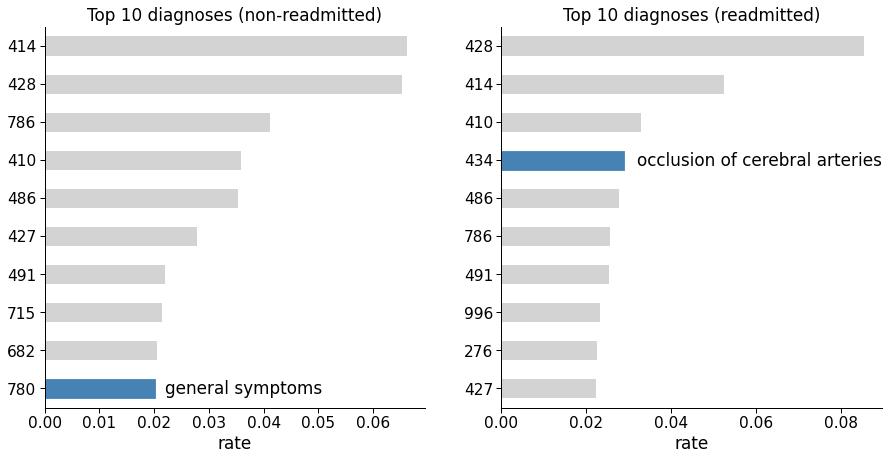

In [191]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nonreadmitted_diag.plot(kind="barh", title="Top 10 diagnoses (non-readmitted)", color="lightgray", ax=ax1)
readmitted_diag.plot(kind="barh", title="Top 10 diagnoses (readmitted)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

ax1.patches[0].set_color("steelblue")
ax2.patches[6].set_color("steelblue")

ax1.text(x=0.022,y=0-0.14,s="general symptoms")
ax2.text(x=0.032,y=6-0.14,s="occlusion of cerebral arteries")

sns.despine()

plt.savefig("../reports/top10diagnoses.png")
plt.show()

### IDs Mapping

Now taking a look at `IDs_mapping.csv`, the file isn't in standard CSV format. It's actually a text file mapping numerical categories to strings. Using this file, I'll replace each number with the appropriate name in the original dataframe.

In [192]:
# Map for admission_type_id
admtype_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=0, nrows=8)

# Map for discharge_disposition_id
discharge_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=10, nrows=30)

# Map for admission_source_id
admsrc_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=42, nrows=25)

Regarding the admission type, not all IDs are used in this dataset (e.g. "emergency"). Maybe "urgent" could be used instead as an indicator of whether the person came in on an emergency or electively.

In [193]:
admtype_map.head(50)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [194]:
admissions = df["admission_type_id"].map(admtype_map["description"].to_dict()).value_counts(normalize=True)
admissions

Urgent           0.558550
Newborn          0.195208
Elective         0.191184
Trauma Center    0.054738
Not Mapped       0.000217
Not Available    0.000103
Name: admission_type_id, dtype: float64

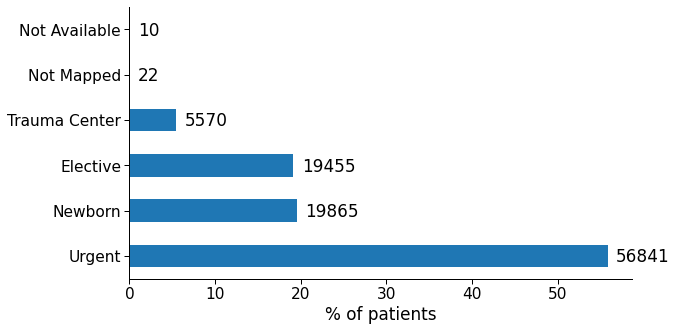

In [195]:
fig, ax = plt.subplots(figsize=(9,5))
(admissions*100).plot.barh(ax)
for index,data in enumerate(admissions.values):
    plt.text(y=index-0.13 , x =data*100+1  , s=f"{int(data*df.shape[0])}" )
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("% of patients")
plt.savefig("../reports/admission_type.png")
plt.show()

### More data set characteristics

- The data set covers a 10-year span (1999-2008).
- Hospital admissions in the data set are supposed to be diabetic-related **only**, but some entries don't have a diabetes-specific ICD-9 code (250.xx). I suppose that, maybe, such diagnosis was made during readmission, which is the reason for it not to show up sometimes.
- Lab tests were performed during admission.
- Medications were administered during admission.
- Data set contains <u>multiple readmissions of the same people</u>.
- Lots of low-variance variables in this data set (e.g. `examide` and `citoglipton` have only 1 unique value), which won't add to the model's predictive power.
- `diag_1` to `diag_3` columns have too many ICD-9-CM codes and will have to be grouped.
- Missing values:
  - `weight` variable is nearly useless, with about 97% of missing values.
  - `payercode` could be an useful variable, but has a concerning number of missing values (around 40%)
  - `medical_specialty` has half of its values missing.

**Target variable:** 30-day remission, i.e. unplanned or unexpected readmission to the same hospital within 30 days of being discharged.

<a id="data-preparation"></a>
## 3. Data preparation


In [196]:
# Keeping the original df intact in case we need it
df2 = df.copy()

### Remove duplicates

There are a few rows in the data set that refer to the same patient number (`patient_nbr`). Most machine learning models require the observations to be independent from each other. More specifically, the assumption is that observations shouldn't come from repeated measurements. To ensure our model's robustness, duplicate entries for the same patient will be deleted (while keeping the first appearance only).

In [197]:
print("df size before:", df.shape[0])
df2 = df2.drop_duplicates(subset="patient_nbr", keep="first")
print("df size after:", df2.shape[0])

df size before: 101766
df size after: 71518


### Drop unneeded features

- `encounter_id`, `patient_nbr`, and `payer_code`: irrelevant to patient outcome
- `weight`, `medical_specialty`: too many missing values.
- `admission_source_id`: redundant variable (`admission_type_id` already contains information about the admission)
- all medications (including the most common: metformin, glimepiride, glipizide, glyburide, pioglitazone, rosiglitazone, and insulin): they either correlated strongly with `diabetesMed`, which indicates if there's any diabetic medication prescribed, or not used at all. 
 

In [198]:
df2 = df2.drop(["encounter_id",
                "patient_nbr",
                "payer_code",
                "weight",
                "medical_specialty",
                "admission_source_id",
                "metformin",
                "glimepiride",
                "glipizide", 
                "glyburide",
                "pioglitazone",
                "rosiglitazone",
                "insulin",   
                "repaglinide",
                "nateglinide",
                "chlorpropamide",
                "acetohexamide",
                "tolbutamide",
                "acarbose",
                "miglitol",
                "troglitazone",
                "tolazamide",
                "examide",
                "citoglipton",
                "glyburide-metformin",
                "glipizide-metformin",
                "glimepiride-pioglitazone",
                "metformin-rosiglitazone",
                "metformin-pioglitazone", 
                ], axis=1)

After dropping the unnecessary features, this is our new set of columns:

In [199]:
df2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

#### Age

The age group feature in this data set is categorical, but can be turned into an ordinal variable. That way we avoid creating too many new features after the one-hot encoding process.

In [200]:
age_map = {'[0-10)': 0,
           '[10-20)': 1,
           '[20-30)': 2,
           '[30-40)': 3,
           '[40-50)': 4,
           '[50-60)': 5,
           '[60-70)': 6,
           '[70-80)': 7,
           '[80-90)': 8,
           '[90-100)': 9}

df2["age"].replace(age_map, inplace=True)

#### Gender

Gender will be converted to either 0 if male or 1 if female.

In [201]:
df2["gender"] = df2["gender"].apply(lambda x: 1 if x == "Female" else 0)

#### Admission type ID

There are 9 distinct values in this column:

In [202]:
admtype_map

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


I'll group this feature by whether patients were admitted in an emergency or not. Thus, "Emergency" (which includes "Urgent") will become 1 and everything else will be 0.

In [203]:
df2["emergency"] = df2["admission_type_id"].apply(lambda x: 1 if x in [1, 2] else 0)
df2.drop("admission_type_id", axis=1, inplace=True)

#### Discharge disposition ID

This feature has 29 distinct features, which would negatively impact the model's performance if we create dummy values for all of them. Therefore, I'm going to restrict these values to either "discharged to home" or other. 

In [204]:
discharge_map.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...


In [205]:
df2["sent_home"] = df2["discharge_disposition_id"].apply(lambda x: 1 if x in [1, 6, 8] else 0)
df2.drop("discharge_disposition_id", axis=1, inplace=True)

#### Diagnosis

The diagnosis features are represented by ICD-9 codes. The idea here is to condensate the hundreds of codes into just a few major groups, based on field knowledge (Strack et al., 2014). I also made sure to include the diagnoses that were among the top 10 for readmitted patients but not for non-readmitted, and vice-versa.


In [206]:
# Make it easier to enter ICD-9 ranges in the dictionary
interval = lambda x,y: list(range(x,y+1))

diag = {
    "Circulatory": interval(390, 433) + interval(435, 459) + [785],  # except 434
    "Respiratory": interval(460,519) + [786],
    "Digestive": interval(520,579) + [786],
    "Diabetes": [250],  # makes sense to give Diabetes a group for its own
    "Injury": interval(800,999),
    "Musculoskeletal": interval(710,739),
    "Genitourinary": interval(580,629) + [788],
    "Neoplasms": interval(140,239),
    "Endocrine": interval(240,249) + interval(251,279),  # except 250
    "General symptoms": [780,781,784] + interval(790,799),  # among the top 10 for non-readmitted
    "Skin": interval(680,709) + [782],
    "Infection": interval(1,139),
    "Mental": interval(290,319),
    "External causes": [1000],  # passed by icd() as 1000, but the code doesn't exist officially
    "Blood": interval(280,289),
    "Nervous": interval(320,359),
    "Pregnancy": interval(630,679),
    "Sense organs": interval(360,389),
    "Congenital": interval(740, 759),
    "Occlusion of cerebral arteries": [434], # among the top 10 for readmitted
    "Unknown": [-1]
}
    
def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis
    
    return : str
    A major diagnostic category.
    """
    if (code[0] != "V") and (code[0] != "E"):
        code = floor(float(code))
    else:
        code = 1000
    for key in diag:
        if code in diag[key]:
            return key
    
    

The missing values will be replaced by -1 so the custom function still works as expected (and we don't lose information).

In [207]:
df2["diag_1"] = df2["diag_1"].fillna("-1").apply(icd)
df2["diag_2"] = df2["diag_2"].fillna("-1").apply(icd)
df2["diag_3"] = df2["diag_3"].fillna("-1").apply(icd)

### Glucose serum test result (max_glu_serum) and A1c test

This variable indicates the range of the test results, or whether the tests were taken at all. It could be be converted into an ordinal variable and spare the creation of unnecessary dummy features. 

In [208]:
df2["A1Cresult"] = df2["A1Cresult"].map({"None": -1, "Norm": 0, ">7": 1, ">8": 2})
df2["max_glu_serum"] = df2["max_glu_serum"].map({"None": -1, "Norm": 0, ">200": 1, ">300": 2})

Also, according to the literature (Strack et al., 2014), adjusting the patient's medication according to HbA1C levels can diminish early readmission rates. Therefore, this new variable is going to be incorporated into the model, and will be 0 if `A1Cresult` is "none" or 1 otherwise. So I want a new variable to check whether a glucose was ordered.

In [209]:
df2["A1C_tested"] = df2["A1Cresult"].apply(lambda x: 0 if x == -1 else 1)
df2["max_glu_serum_tested"] = df2["max_glu_serum"].apply(lambda x: 0 if x == -1 else 1)

#### Change of medication

Converting object type to numerical:

In [210]:
df2["change"] = df2["change"].apply(lambda x: 1 if x == "Ch" else 0)

#### Diabetes medications
Converting object type to numerical:

In [211]:
df2["diabetesMed"] = df2["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)

In [212]:
# The drugs used during the inpatient setting have each four different values, representing whether the drug was upregulated, downregulated, stayed the same, or wasn't used at all. The amount of unique information is going to flood the model with multicollinearity, since a medication change (either of type or dosage) is already being reported by the variable `change`. But I still want to see whether the type of medication plays a role in predicting early readmission. Therefore, I'm going to set each medication variable to 1 if it was used and 0 otherwise.

In [213]:
# drug_cols = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
#        'rosiglitazone', 'insulin']

# for col in drug_cols:
#     df2[col] = df2[col].apply(lambda x: 0 if x == "No" else 1)

# #df3.drop(drug_cols, axis=1, inplace=True)

#### Readmitted (target variable)

Setting the variable to 1 if readmitted earlier than 30 days, 0 otherwise.

In [214]:
df2['readmitted'] = df2['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

#### Dummy variables creation

All categorical variables are going to be converted into dummy variables (one-hot encoding).

In [215]:
df2 = pd.get_dummies(df2, dummy_na=False, drop_first=False)

#### Merging diag_n variables

The `diag` features represent what the physician thought would be the causes of the patient admission. As a rule, the primary (principal) cause of admission should be the `diag_1` variable. `diag_2` and `diag_3` variables are left for secondary causes. To avoid passing too many dummy variables to the model, I'm going to merge the three features into a weighted sum.

Example: if a patient has diag_1_Circulatory = 1, diag_2_Circulatory = 1, and diag_3_Circulatory = 0, the weighted sum is going to be diag_Circulatory = 1x3 + 1x2 + 0x1 = 5.

In [216]:
for disease in diag:
    df2[f"diag_{disease}"] = df2[f"diag_1_{disease}"]*3 + df2[f"diag_2_{disease}"]*2 + df2[f"diag_3_{disease}"]*1 
    df2.drop([f"diag_{n}_{disease}" for n in range(1,4)], axis=1, inplace=True)

#### Analysis of correlated variables

A final check for correlated variables, and see if any one variable could cause a large amount of problem to the model's prediction. Highly-correlated variables (0.7 and above) may result in unstable models. This is especially true for logistic regression models.

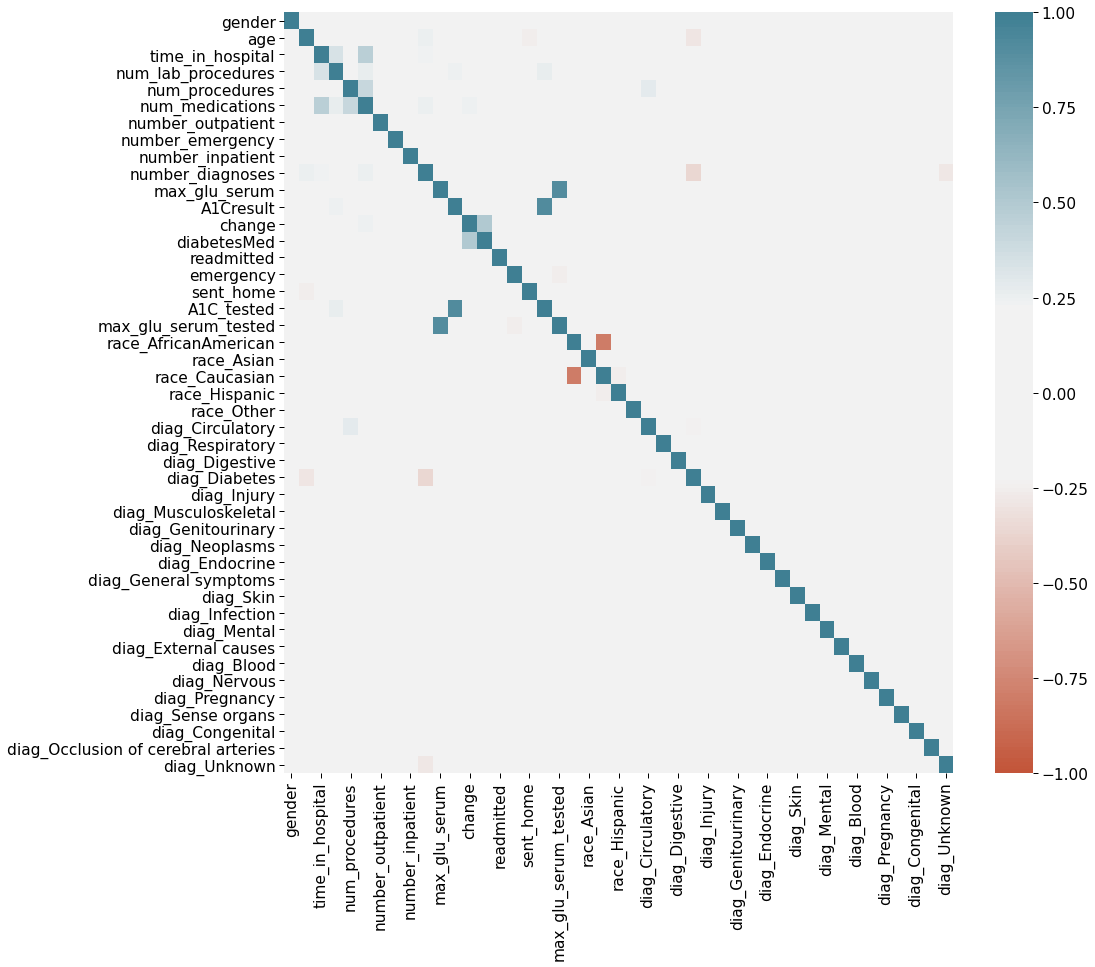

In [217]:
corr = df2.corr(method='pearson')
plt.figure(figsize=(15,14))

sns.heatmap(corr,
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200, sep=60)  # tunned so that 0.30 starts to appear
           )
plt.savefig("../reports/correlation.png")

In [218]:
abscorr = corr.abs()
corr_list = abscorr.unstack().sort_values(kind="quicksort", ascending=False)
corr_list[(corr_list > 0.5) & (corr_list != 1)]

A1C_tested            A1Cresult               0.917508
A1Cresult             A1C_tested              0.917508
max_glu_serum         max_glu_serum_tested    0.902445
max_glu_serum_tested  max_glu_serum           0.902445
race_Caucasian        race_AfricanAmerican    0.807590
race_AfricanAmerican  race_Caucasian          0.807590
change                diabetesMed             0.506697
diabetesMed           change                  0.506697
dtype: float64

As expected, `A1Cresult` is strongly correlated with the engineered feature `A1Ctested`. The same is valid for `max_glu_serum_tested` and `max_glu_serum`.

After a few tests, I concluded that these values were not sufficient to affect the models' performance (and in fact, even helped them).

In [219]:
# # Drop variables that are above the 0.7 absolute correlation threshold
# df2.drop([
#     "race_Caucasian",  
#     "A1C_tested",
#     "max_glu_serum_tested"
# ] , axis=1, inplace=True)

#### Summary of transformed data set

In [220]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   gender                               71518 non-null  int64
 1   age                                  71518 non-null  int64
 2   time_in_hospital                     71518 non-null  int64
 3   num_lab_procedures                   71518 non-null  int64
 4   num_procedures                       71518 non-null  int64
 5   num_medications                      71518 non-null  int64
 6   number_outpatient                    71518 non-null  int64
 7   number_emergency                     71518 non-null  int64
 8   number_inpatient                     71518 non-null  int64
 9   number_diagnoses                     71518 non-null  int64
 10  max_glu_serum                        71518 non-null  int64
 11  A1Cresult                            71518 non-null  

<a id="modeling"></a>

## Modeling

In [221]:
y = df2['readmitted'].values
X = df2.drop("readmitted", axis=1).values

75/25 split of the data set into training/test sets:

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33634)

#####  Logistic Regression

The machine learning pipeline has several steps which seemed pertinent, such as:

- Standardizing the training set to guarantee a faster convergence;
- Drop variables that have null variance (thus not containing relevant information);
- Selection of most relevant features based on ANOVA test between each feature and the target variable (ANOVA was the test of choice because of speed, and also because the chi2 test requires values to be positive, which wouldn't be the case after they are standardized by the StandardScaler);
- The machine learning model itself.

In [223]:
lr = Pipeline([    
        ("scaler", StandardScaler()),
        ("varthres", VarianceThreshold()),
        ("select", SelectKBest(f_classif, k=40)),
        ("clf", LogisticRegression(random_state=33634, 
                                   max_iter=1000, 
                                   solver="saga",
                                   C=0.01,
                                   penalty="l1",
                                   class_weight="balanced"))
    ])    

if OPTIMIZE:
    lr_params = {
            "select__k": range(2, X.shape[1]),        
            'clf__penalty':["none", "l2", "l1"],
            'clf__C': np.logspace(-3,3,7)        
        }

    grid = GridSearchCV(lr, 
                       lr_params,
                       cv=5, 
                       scoring="roc_auc",
                       verbose=10, 
                       n_jobs=5,                   
                     )

    grid.fit(X_train, y_train)
    print('Best Score:', grid.best_score_)
    print('Best Hyperparameters:', grid.best_params_)
    lr = grid.best_estimator_

else:
    lr.fit(X_train, y_train)

In [224]:
rf = RandomForestClassifier(n_estimators=1000,
                            random_state=33634,
                            class_weight="balanced",
                            max_depth=30,
                            min_samples_leaf=10,
                            min_samples_split=150)

if OPTIMIZE:
    rf_params = {
        "criterion": ["gini", "entropy"],
        "max_depth": [8, 13, 21, 34, 55],
        "min_samples_split": [55, 89, 144, 233],
        "min_samples_leaf": [3, 5, 8, 13, 21, 34],
        "max_features": ["sqrt", "log2", None],
        "oob_score": [True, False],                 
    }
    
    gridrf = GridSearchCV(rf, 
                       rf_params,
                       cv=5, 
                       scoring="roc_auc",
                       verbose=10, 
                       n_jobs=5, 
                       )
    gridrf.fit(X_train, y_train)
    print('Best Score:', gridrf.best_score_)
    print('Best Hyperparameters:', gridrf.best_params_)
    rf = gridrf.best_estimator_
else:
    rf.fit(X_train, y_train)



## Evaluation

##### Machine learning model performance and most informative variables

These are the metrics of the **Logistic Regression** model when tested against the testing set:

In [225]:
print("Precision: ", precision_score(y_test, lr.predict(X_test)))
print("Recall: ", recall_score(y_test, lr.predict(X_test)))
print("F1: ", f1_score(y_test, lr.predict(X_test)))
print("ROC: ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Precision:  0.13595594020456334
Recall:  0.5403377110694184
F1:  0.21724918280110633
ROC:  0.6355722449373435


These are the metrics of the **Random Forest** model when tested against the testing set:

In [226]:
print("Precision: ", precision_score(y_test, rf.predict(X_test)))
print("Recall: ", recall_score(y_test, rf.predict(X_test)))
print("F1: ", f1_score(y_test, rf.predict(X_test)))
print("ROC: ", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Precision:  0.1691240242844753
Recall:  0.36585365853658536
F1:  0.2313167259786477
ROC:  0.6550538945879318


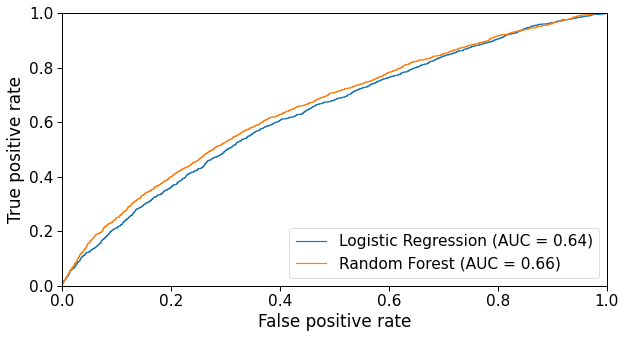

In [227]:
fig, ax = plt.subplots(figsize=(9,5))
plot_roc_curve(lr, X_test, y_test, ax=ax, name="Logistic Regression")
plot_roc_curve(rf, X_test, y_test, ax=ax, name="Random Forest")
plt.margins(x=0, y=0)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.tight_layout()
plt.savefig("../reports/roc.png")

According to the AUC, the Random Forest performs slightly better than the Logistic Regression, so we are going to use its coefficients (feature importances) as a basis for our analysis.

This is how each feature affected the machine learning model's prediction:

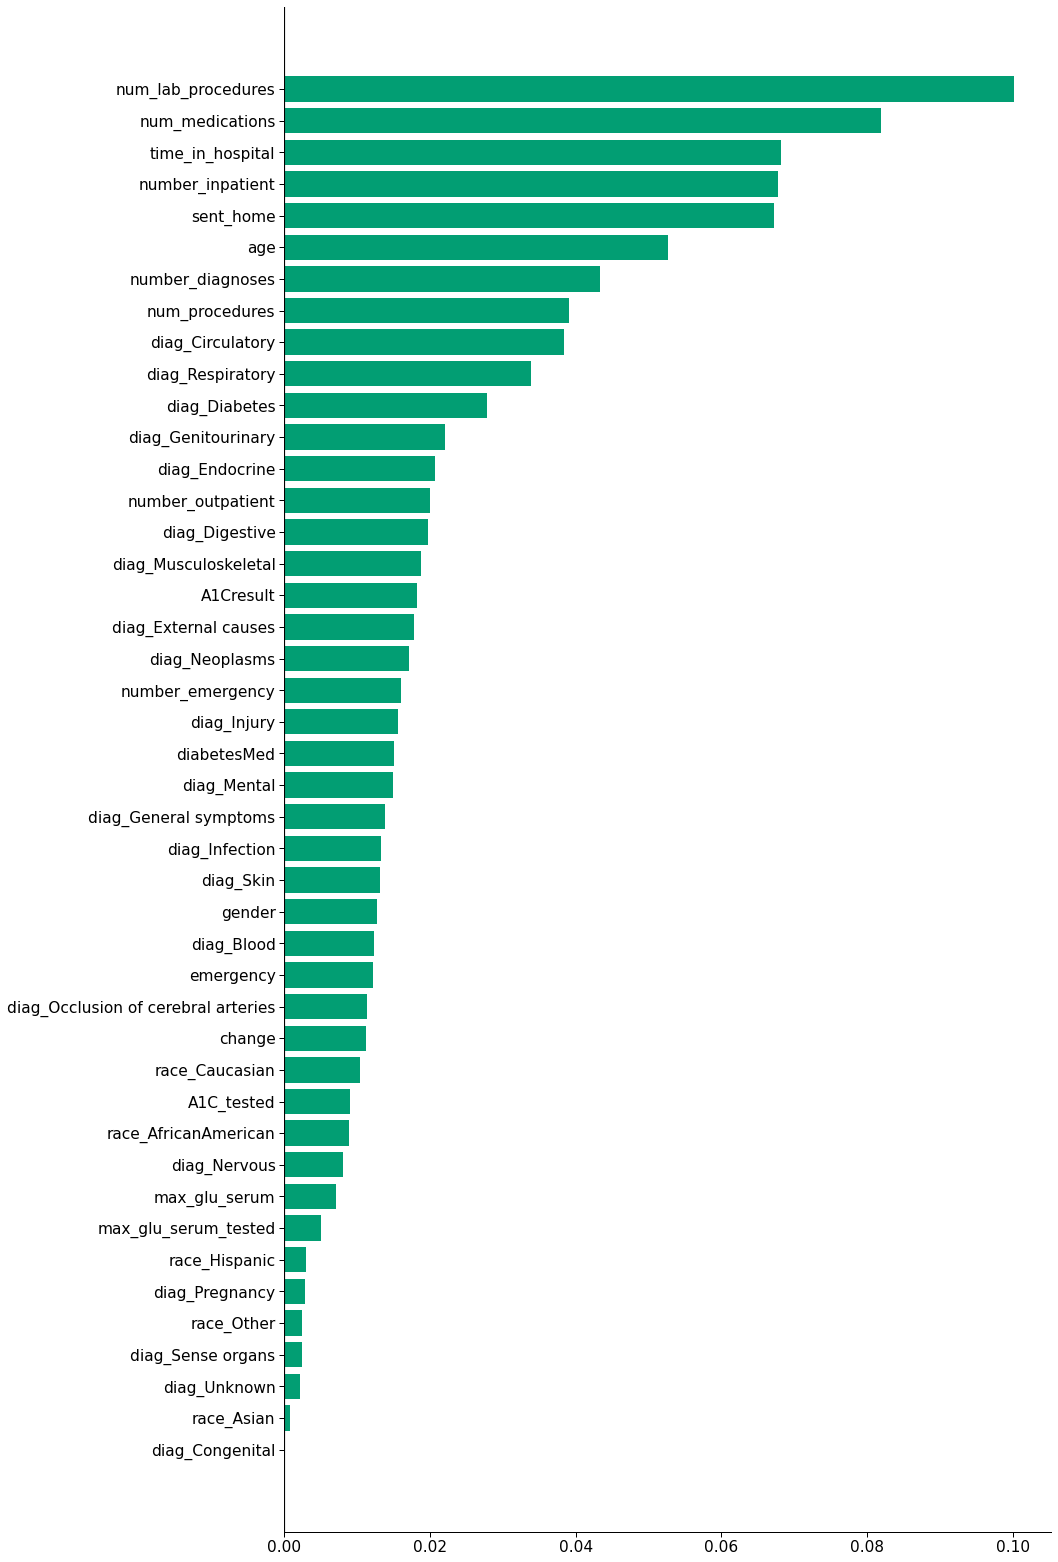

In [228]:
# get the coefficients from tunned model
coefs = rf.feature_importances_

# retrieve which features were selected by the feature selection part of the pipeline
# mask_vars = grid.best_estimator_["varthres"].get_support()
# mask_select = grid.best_estimator_["select"].get_support()
features = df2.drop("readmitted", axis=1).columns #.values[mask_vars][mask_select]

# plot selected features and their coefficients
palette = sns.color_palette("colorblind").as_hex()
colors = [palette[3] if x < 0 else palette[2] for x in coefs[coefs.argsort()]]
pos = range(len(coefs))
plt.figure(figsize=(15, len(coefs)*0.5))
plt.barh(pos, coefs[coefs.argsort()], color=colors)
plt.yticks(pos, features[coefs.argsort()])
plt.axvline(x=0, color='.2')
sns.despine()
plt.tight_layout()
plt.savefig("../reports/coef.png")
plt.show()

In an ensemble model like the Random Forest, every feature count as a vote in the final prediction, even if they are highly correlated or uninmportant (although they may have a smaller weight in the decision).

I'm going to focus on the 10 most important features according to the model:



`time_in_hospital`, `num_lab_procedures`, `num_medications`, `number_diagnoses` and `num_procedures`


These five variables are highly correlated, and it makes sense: the longer you stay in hospital, the more medications, lab procedures, diagnoses and general procedures you're likely to be subjected to.

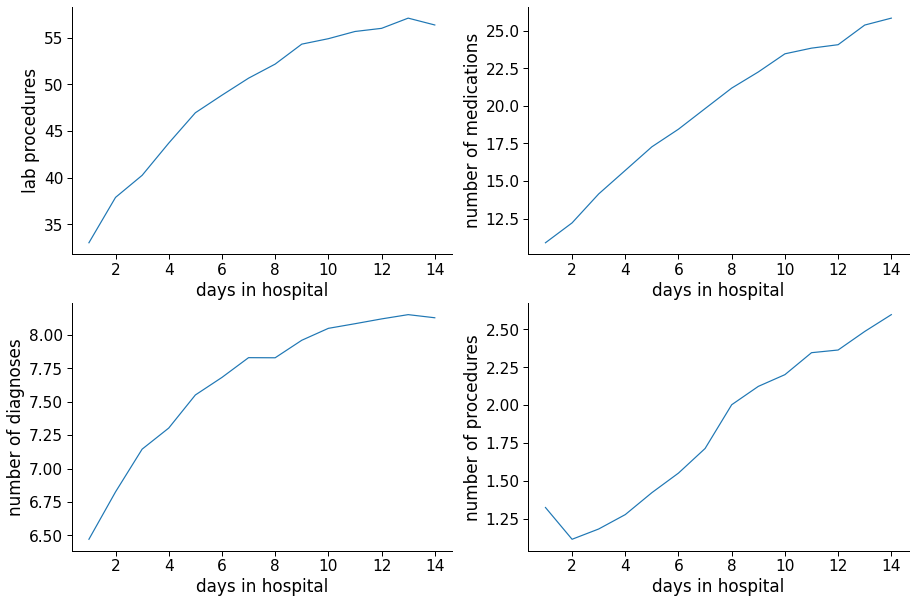

In [229]:
sns.set_context('paper', font_scale=1.75)
fig, axs = plt.subplots(2,2, figsize=(15,10))

df2.groupby("time_in_hospital")[["num_lab_procedures"]].mean().plot(ax=axs[0,0],
                                                                    legend=None,
                                                                    xlabel="days in hospital",
                                                                    ylabel="lab procedures")
df2.groupby("time_in_hospital")[["num_medications"]].mean().plot(ax=axs[0,1],
                                                                    legend=None,
                                                                    xlabel="days in hospital",
                                                                    ylabel="number of medications")
df2.groupby("time_in_hospital")[["number_diagnoses"]].mean().plot(ax=axs[1,0],
                                                                    legend=None,
                                                                    xlabel="days in hospital",
                                                                    ylabel="number of diagnoses")
df2.groupby("time_in_hospital")[["num_procedures"]].mean().plot(ax=axs[1,1],
                                                                    legend=None,
                                                                    xlabel="days in hospital",
                                                                    ylabel="number of procedures")
sns.despine()

And how does staying longer affect readmission? It seems that a longer hospital stays do not imply into less readmissions. Quite the opposite: the longer the stay, the higher the likelihood of admission (see figure below). It is not possible to tell if a prolonged stay worsens the patient's health and increase their chance of readmission, because correlation that doesn't imply causation. Most likely, the longer stay is precisely a sign that the patient's health is fragile, hence the higher probability of readmission within 30 days.

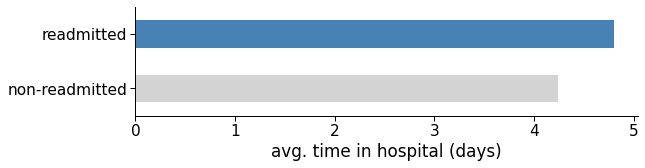

In [230]:
plt.figure(figsize=(9,2))
df2.groupby("readmitted")["time_in_hospital"].mean().plot.barh(color=["lightgray", "steelblue"])
plt.xlabel("avg. time in hospital (days)")
plt.yticks(ticks=[0,1], labels=["non-readmitted", "readmitted"])
plt.ylabel(None)
sns.despine()

`number_inpatient`

Or number of inpatient visits in the year preceding the encounter). The model suggests that the more often patients have been admitted in the previous year, the higher the likelihood they'll be readmitted in the future. Let's call this a darker version of the Lindy Effect: "if you have been to a hospital last year, you'll probably visit it again this year too."

This could be an indirect indicator of the patient's health, which may correlate with the number of hospital visits.

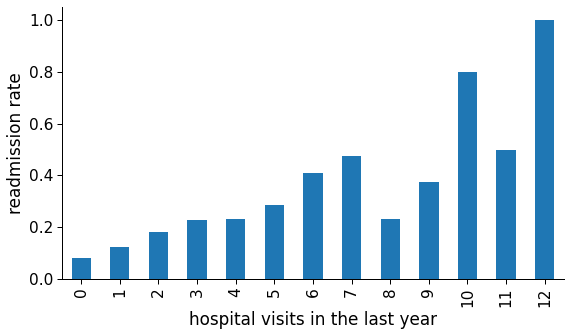

In [231]:
plt.figure(figsize=(9,5))
df2.groupby("number_inpatient")["readmitted"].mean().plot.bar()
plt.xlabel("hospital visits in the last year")
plt.ylabel("readmission rate")
sns.despine()

`age`

As expected, older patients are more prone to unexpected complications and, consequently, early readmissions. They also take longer to recover, as observed in the graph below. In that case, it's recommended that hospitals be more incisive with older patients when it comes to preemptive measures.

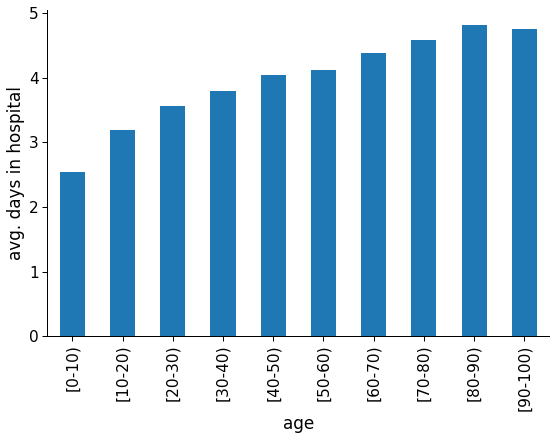

<Figure size 648x360 with 0 Axes>

In [232]:
sns.color_palette("flare")
fig, ax = plt.subplots(figsize=(9,6))
plt.figure(figsize=(9,5))
df.groupby("age")[["time_in_hospital"]].mean().plot.bar(ax=ax, legend=None)
sns.despine(ax=ax)
ax.set_ylabel("avg. days in hospital")
plt.show()

`sent_home`

The rationale behind this engineered feature was that going home from the hospital (either due to discharge or continued treatment) could cause positive impact on the patient's recovering, so much so that they would be at lesser risk of readmission.

However, non-readmission doesn't necessarily mean recovery. There are other reasons for a patient not showing up, like ggaving up on electively going to the hospital again, being transferred to a hospice, or death.

Either way, this engineered feature was one of the most informative features according to the model and could be used at least partially to account for future readmissions. According to the data, around 60% of the patients who were readmitted had been sent home, while more than 75% of the non-readmitted.

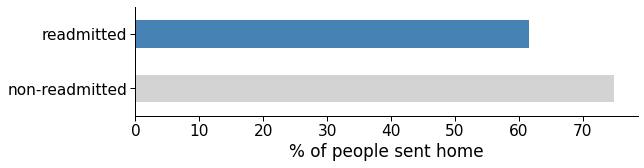

In [233]:
plt.figure(figsize=(9,2))
(df2.groupby("readmitted")["sent_home"].mean()*100).plot.barh(color=["lightgray", "steelblue"])
plt.xlabel("% of people sent home")
plt.yticks(ticks=[0,1], labels=["non-readmitted", "readmitted"])
plt.ylabel(None)
sns.despine()

### Further questions

Now that we have treated the data set and trained a model, we can start answering other key questions of this work.

##### Were readmitted diabetic patients correctly diagnosed in their first admission?

It is known that all encounters in the data set are diabetes-related, even if diabetes doesn't show up in any of the diagnoses columns. One possible cause of this is that diabetes wasn't correctly spotted the first time the patient was admitted in the hospital. So does an early detection of diabetes prevent patients from being readmitted later on?

In [234]:
correct_diag = pd.DataFrame()
correct_diag["average"] = df2.groupby("readmitted")["diag_Diabetes"].mean()
correct_diag["stdev"] = df2.groupby("readmitted")["diag_Diabetes"].std()/np.sqrt(len(df2))
correct_diag

,average,stdev
readmitted,,
0,0.694258,0.003747
1,0.684888,0.003811


In [235]:
from sklearn.feature_selection import f_regression
f_test = f_classif(df2.diag_Diabetes.values.reshape(-1,1), df2.readmitted.values.reshape(-1,1))
print("F-value: ", f_test[0][0])
print("p-value: ", f_test[1][0])

F-value:  0.5003727
p-value:  0.47933870831929015


Since $p > 0.05$, we can't reject the null hypothesis (at a 95% confidence level). 

##### How often HbA1c exams are asked by physicians in the inpatient setting?

According to the data set, some patients diagnosed with diabetes didn't have their HbA1c levels checked, and those were more likely of being readmitted within 30 days. 

In [236]:
print("Non-readmitted:", (df2[(df2.readmitted == 0) & (df2.diag_Diabetes > 0)]["A1Cresult"] >= 0).mean() * 100)
print("Readmitted:", (df2[(df2.readmitted == 1) & (df2.diag_Diabetes > 0)]["A1Cresult"] >= 0).mean() * 100)

Non-readmitted: 22.766049455517553
Readmitted: 20.65033783783784


High HbA1c levels is one of the key indicators of diabetes. Maybe if the doctors asked for a test, they could see that a medication change was needed. The data shows that once A1c levels are assessed, a medication change is more likely to occur.

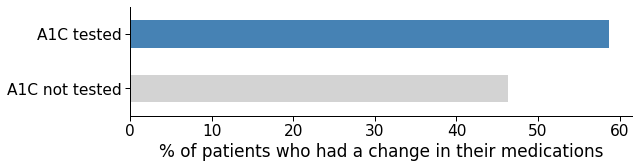

In [237]:

plt.figure(figsize=(9,2))
(df2[(df2.diag_Diabetes > 0)].groupby("A1C_tested")['change'].mean()*100).plot.barh(color=["lightgray", "steelblue"])
plt.xlabel("% of patients who had a change in their medications")
plt.yticks(ticks=[0,1], labels=["A1C not tested", "A1C tested"])
plt.ylabel(None)
sns.despine()

### Summary of insights

- Time in hospital (and indirectly number of lab procedures, number of procedures, and number of medications) could be an indicator of the patient's health. The longer the stay, the higher the probability of being readmitted within 30 days.
- Number of inpatient visits in the last year could also be an indicator of the patient's health, but longer term. It's also strongly correlated with early readmission.
- The older the patient, the higher the probability of early readmission after discharge.
- People who were sent home are less likely to return within 30 days.
- Even after being diagnosed with diabetes-related symptoms, patients who didn't have their HbA1c levels checked were more prone to early readmission, most likely because they needed a medication change.
 

<a id="references"></a>
## References

Cheng, S.-W., Wang, C.-Y., & Ko, Y. (2019). Costs and Length of Stay of Hospitalizations due to Diabetes-Related Complications. Journal of Diabetes Research, 2019, 1–6. https://doi.org/10.1155/2019/2363292

Graham, K. L., Auerbach, A. D., Schnipper, J. L., Flanders, S. A., Kim, C. S., Robinson, E. J., Ruhnke, G. W., Thomas, L. R., Kripalani, S., Vasilevskis, E. E., Fletcher, G. S., Sehgal, N. J., Lindenauer, P. K., Williams, M. V., Metlay, J. P., Davis, R. B., Yang, J., Marcantonio, E. R., & Herzig, S. J. (2018). Preventability of Early Versus Late Hospital Readmissions in a National Cohort of General Medicine Patients. Annals of Internal Medicine, 168(11), 766–774. https://doi.org/10.7326/M17-1724

Leppin, A. L., Gionfriddo, M. R., Kessler, M., Brito, J. P., Mair, F. S., Gallacher, K., Wang, Z., Erwin, P. J., Sylvester, T., Boehmer, K., Ting, H. H., Murad, M. H., Shippee, N. D., & Montori, V. M. (2014). Preventing 30-Day Hospital Readmissions: A Systematic Review and Meta-analysis of Randomized Trials. JAMA Internal Medicine, 174(7), 1095. https://doi.org/10.1001/jamainternmed.2014.1608

Robinson, R., & Hudali, T. (2017). The HOSPITAL score and LACE index as predictors of 30 day 
readmission in a retrospective study at a university-affiliated community hospital. PeerJ, 5, e3137. https://doi.org/10.7717/peerj.3137

Rubin, D. J. (2015). Hospital Readmission of Patients with Diabetes. Current Diabetes Reports, 15(4), 17. https://doi.org/10.1007/s11892-015-0584-7

Smeraglio, A., Heidenreich, P. A., Krishnan, G., Hopkins, J., Chen, J., & Shieh, L. (2019). “Patient vs provider perspectives of 30-day hospital readmissions.” BMJ open quality, 8(1), e000264. https://doi.org/10.1136/bmjoq-2017-000264

Soh, J. G. S., Wong, W. P., Mukhopadhyay, A., Quek, S. C., & Tai, B. C. (2020). Predictors of 30-day unplanned hospital readmission among adult patients with diabetes mellitus: A systematic review with meta-analysis. BMJ Open Diabetes Research & Care, 8(1), e001227. https://doi.org/10.1136/bmjdrc-2020-001227

Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records. BioMed Research International, 2014, 1–11. https://doi.org/10.1155/2014/781670

Swami, J., Donihi, A., Siminerio, L. M., French, E. K., Delisi, K., Hlasnik, D. S., Patel, N., Pinkhasova, D., Rubin, D. J., & Korytkowski, M. T. (2018). Readmission and Comprehension of Diabetes Education at Discharge (ReCoDED Study). Diabetes, 67(Supplement 1), 147-LB. https://doi.org/10.2337/db18-147-LB